# IML Take-Home Assignment 3

_Your names here_

## Problem 1
> Consider the following interface for machine learning "modules" that can be chained together in series. (If you like, you can return to this code later and add features like debug information / hooks.)

In [22]:
import numpy as np
from math import sqrt


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        return x

    def backward(self, dy: np.ndarray) -> np.ndarray:
        return dy

    def step(self):
        pass


class Sequential(Module):
    def __init__(self, *components: Module):
        self.components: tuple[Module, ...] = components

    def forward(self, x):
        for c in self.components:
            x = c(x)
        return x

    def backward(self, dy):
        for c in reversed(self.components):
            dy = c.backward(dy)
        return dy

    def step(self):
        for c in self.components:
            c.step()

> **Fill in the following implementation of a "linear layer."** In writing, explain the meaning of the "backward pass" and how you derived the expressions involved. _(3 points)_

In [23]:
from dataclasses import dataclass
from numpy.random import randn


@dataclass
class Linear(Module):
    d_in: int
    d_out: int
    init_scale: float = 1
    learning_rate: float = 1

    def __post_init__(self):
        self.weights = self.init_scale * randn(self.d_in, self.d_out)
        self.grad = np.zeros_like(self.weights)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        return x @ self.weights

    def backward(self, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    def step(self):
        self.weights -= self.learning_rate * self.grad

## Problem 2
> The following class wlll train a model on a synthetic regression problem and display the learned function.

In [24]:
from typing import Callable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


class RegressionProblem:
    def __init__(
        self,
        model: Module,
        fn: Callable[[np.ndarray], np.ndarray],
    ):
        self.model = model
        self.b = 50
        self.x = np.linspace(0, 1, self.b)[:, None]  # shape: (b, 1)
        self.y = fn(self.x) + 0.1 * randn(self.b, 1)  # shape: (b, 1)

    def train(self, iters=10) -> pd.Series:
        losses = np.zeros(iters)
        for i in range(iters):
            y_hat = self.model(self.x)
            losses[i] = ((y_hat - self.y) ** 2).sum(axis=1).mean()
            self.model.backward((y_hat - self.y) / self.b)
            self.model.step()
        series = pd.Series(losses, name="Mean squared error")
        series.index.name = "Iteration"
        return series

    def show(self):
        df = pd.DataFrame({"x": self.x.flatten(), "y": self.y.flatten()})
        sns.scatterplot(df, x="x", y="y")
        x_sample = np.linspace(-0.2, 1.2, 100)[:, None]
        plt.plot(x_sample, self.model(x_sample))

> Using your implementation of `Linear` above, **define a `Sequential` model that learns a function of the form $y = a x + b$** by applying a suitable "embedding" before your linear layer. (Define a module to perform your embedding.) Does the embedding need a backward pass? _(3 points)_

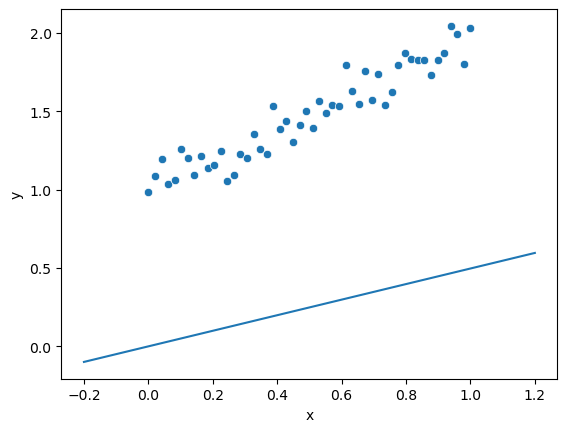

In [25]:
np.random.seed(42)
model = Sequential(
    # <- Add an embedding here?
    Linear(1, 1),  # A learnable linear map
)
problem = RegressionProblem(model, lambda x: x + 1)
# problem.train(100)
problem.show()

## Problem 3
> Now, let's solve a non-linear regression problem using a very simple neural network with a fixed (untrainable) hidden layer.
>
> Let $(r_i)_{i = 1}^d$ be a sequence of $d$ "reference inputs" and let $x$ be the input to the network. For each $i = 1, \dots, d,$ let the hidden neuron $h_i$ equal $1$ if $r_i$ is the reference input closest to $x$ and $0$ otherwise. Finally, let the output $y$ of the network be a linear combination
> $$
y = \sum_{i = 1}^d w_i h_i.
$$
>
> The following code implements such a network. **Analytically derive the optimal weights $w_i$ for this network under a squared error loss.** What is this network really learning? _(3 points)_

In [26]:
class LocalEmbedding(Module):
    def __init__(self, references: np.ndarray):
        self.references = references  # (d_embed, d_in)
        self.d_embed, self.d_in = self.references.shape

    def forward(self, x):
        b = x.shape[0]
        out = np.zeros((b, self.d_embed))
        distances = np.sum((self.references[None] - x[:, None, :]) ** 2, axis=-1)
        out[np.arange(b), np.argmin(distances, axis=-1)] = 1
        return out

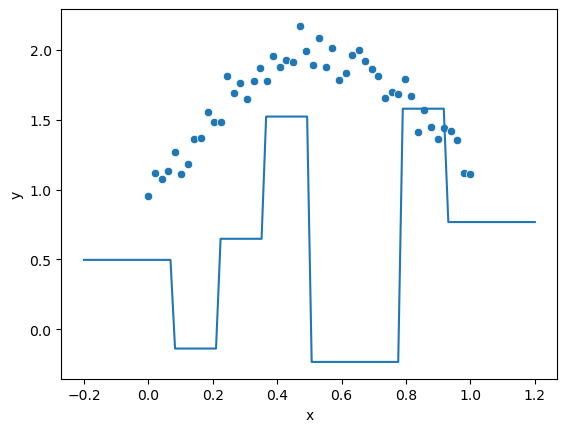

In [27]:
np.random.seed(42)
model = Sequential(
    LocalEmbedding(np.linspace(0, 1, 8)[:, None]),
    Linear(8, 1),
)
problem = RegressionProblem(model, lambda x: np.sin(3 * x) + 1)
# problem.train(50)
problem.show()

## Problem 4
> Now we'll make the hidden neurons learnable. Each hidden neuron $h_i$ should compute $\sigma(a_i x + b_i),$ where $\sigma$ is the "logistic sigmoid function" $\sigma(x) = 1 / (1 + e^{-x})$  and $(a_i, b_i)$ are learnable parameters. As before, the output $y$ will be a learnable linear function of the hidden neurons $h_i.$
>
> **Implement and train this two-layer MLP on the same problem as above.** Use 16 hidden neurons. Find hyperparameters that make the network converge to a reasonable model in only 200 iterations. Graph the function learned by the network. _(5 points)_

In [28]:
class Sigmoid(Module):
    def forward(self, x):
        self.x = x
        return 1 / (1 + np.exp(-x))

    def backward(self, dy):
        raise NotImplementedError()

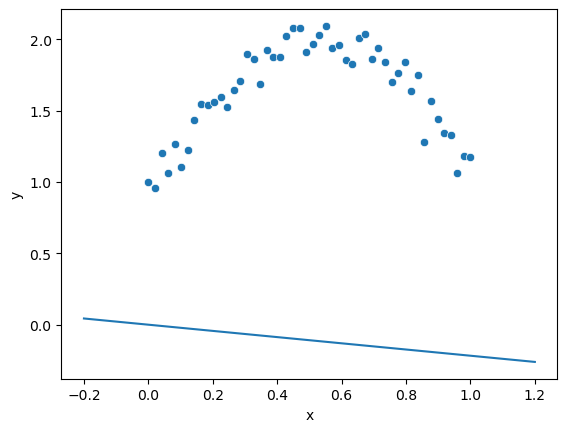

In [29]:
def make_simple_mlp(d_embed=16):
    return Sequential(
        # <- Something here?
        Linear(1, d_embed, init_scale=1, learning_rate=d_embed),
        # <- Something here?
        Linear(d_embed, 1, init_scale=1 / d_embed, learning_rate=1 / d_embed),
    )


np.random.seed(42)
problem = RegressionProblem(make_simple_mlp(), lambda x: np.sin(3 * x) + 1)
# problem.train(200)
problem.show()

## Problem 5
> The following class will train a model on a synthetic classification problem and display the learned classifier.

In [30]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from numpy.random import randn

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


def make_cluster(mean, n_points: int, label: int):
    return pd.DataFrame(
        {
            "x": mean[0] + 0.2 * randn(n_points),
            "y": mean[1] + 0.2 * randn(n_points),
            "label": label,
        }
    )

class ClassificationProblem:
    def __init__(self, model):
        self.model = model
        self.n_clusters = 3
        self.df = pd.concat(
            [
                make_cluster([1, 1], 50, 0),
                make_cluster([-1, 1], 50, 1),
                make_cluster([-1, -1], 50, 0),
                make_cluster([1, -1], 50, 1),
                make_cluster([0, 0], 50, 2),
            ],
            axis=0,
        )

    def train(self, n_iters=100):
        loss = np.zeros(n_iters)
        for i in tqdm(range(n_iters)):
            # Forward pass
            self.model(self.df[["x", "y"]].to_numpy())
            # Backward pass using the true labels
            self.model.backward(self.df["label"].to_numpy())
            # Store the loss from the last layer
            loss[i] = self.model.components[-1].loss
            # Gradient step
            self.model.step()
        return loss

    def show(self, palette: str = "bright"):
        from matplotlib.colors import ListedColormap

        extent = (-2, 2, -2, 2)

        x, y = np.meshgrid(
            np.arange(*extent[:2], step=0.01),
            np.arange(*extent[2:], step=0.01),
        )
        colors = sns.color_palette(palette, n_colors=self.n_clusters)
        out = self.model(np.stack([arr.flatten() for arr in [x, y]], axis=1))
        plt.matshow(
            out.reshape(x.shape)[::-1, :],
            extent=extent,
            alpha=0.3,
            cmap=ListedColormap(colors),
        )
        sns.scatterplot(self.df, x="x", y="y", hue="label", palette=palette)
        plt.show()

> **Build a two-layer MLP** and train it on this problem. Requirements:
>
> - Use the ReLU activation function for the hidden layer.
> - Use a softmax on the output layer to generate a vector of probabilities.
> - Train the network with cross-entropy loss.
>
> `ClassificationProblem.train()` expects that the backwards pass of your `Module` accepts a vector of true classes, and that its last layer computes a `loss` attribute. Feel free to edit this if you want. _(6 points)_

In [31]:
@dataclass
class CrossEntropyLoss(Module):
    n_classes: int

    def forward(self, x):
        self.y_pred = x  # Store for backward pass
        return np.argmax(x, axis=1)

    def backward(self, dy):
        batch_size = dy.shape[0]
        # One-hot encoding of the true labels
        y_true = np.zeros((batch_size, self.n_classes))
        y_true[np.arange(batch_size), dy] = 1.0

        # Cross-entropy loss:
        eps = 1e-15
        correct_class_probs = self.y_pred[np.arange(batch_size), dy]
        self.loss = -np.mean(np.log(correct_class_probs + eps))

        # Gradient of cross-entropy wrt input probabilities:
        dx = (self.y_pred - y_true) / batch_size
        return dx

def make_classifier():
    # Two-layer MLP:
    # Input: 2D (x,y)
    # Hidden layer: use ReLU
    # Output layer: 3 classes -> use Softmax
    return Sequential(
        Linear(2, 10),
        ReLU(),
        Linear(10, 3),
        Softmax(),
        CrossEntropyLoss(n_classes=3),
    )

np.random.seed(42)
problem = ClassificationProblem(model=make_classifier())
# Uncomment the next line to actually train the model
# loss_values = problem.train(100)
problem.show()

NameError: name 'ReLU' is not defined

## Problem 6 (Bonus)
> Build a neural network that can learn addition modulo 10. The architecture is up to you!
>
> Requirements:
>
> - _Do not_ encode numbers directly as input values. Instead, use one-hot embeddings or randomly initialized, learnable embeddings.
> - Reserve a very small fraction of data points to compute test loss.
> - Graph test loss and training loss over many epochs of full-batch gradient descent.
>
> For full points, test loss should drop to 0. _(4 points)_

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# ----------------------
# 1. Prepare Data
# ----------------------
digits = list(range(10))
all_pairs = [(a, b) for a in digits for b in digits]

# Reserve a small fraction for testing, e.g. 5 pairs
random.shuffle(all_pairs)
test_pairs = all_pairs[:5]
train_pairs = all_pairs[5:]

# Convert data to tensors
def make_batch(pairs):
    # Inputs: two columns of integers
    a = torch.tensor([p[0] for p in pairs], dtype=torch.long)
    b = torch.tensor([p[1] for p in pairs], dtype=torch.long)
    # Labels: (a + b) % 10
    labels = torch.tensor([(p[0] + p[1]) % 10 for p in pairs], dtype=torch.long)
    return a, b, labels

train_a, train_b, train_labels = make_batch(train_pairs)
test_a, test_b, test_labels = make_batch(test_pairs)

# ----------------------
# 2. Define Model
# ----------------------
class Mod10AdditionNet(nn.Module):
    def __init__(self, embedding_dim=8, hidden_dim=16):
        super(Mod10AdditionNet, self).__init__()
        # Learnable embeddings for digits 0-9
        self.embedding = nn.Embedding(num_embeddings=10, embedding_dim=embedding_dim)
        
        # A small MLP
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 10)
        
    def forward(self, a, b):
        # Embed each input digit
        emb_a = self.embedding(a)  # [batch, embedding_dim]
        emb_b = self.embedding(b)  # [batch, embedding_dim]
        
        # Concatenate embeddings
        x = torch.cat([emb_a, emb_b], dim=-1)
        
        # MLP
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # [batch, 10]
        return x

model = Mod10AdditionNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# ----------------------
# 3. Training Loop
# ----------------------
epochs = 200
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass on all training examples (full batch)
    train_outputs = model(train_a, train_b)
    train_loss = criterion(train_outputs, train_labels)
    # Backprop
    train_loss.backward()
    optimizer.step()
    
    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_a, test_b)
        test_loss = criterion(test_outputs, test_labels)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# ----------------------
# 4. Check Results
# ----------------------
# Print final losses and accuracy
print("Final Training Loss:", train_losses[-1])
print("Final Test Loss:", test_losses[-1])

# Check predictions on test set
with torch.no_grad():
    preds = torch.argmax(model(test_a, test_b), dim=1)
correct = (preds == test_labels).sum().item()
print(f"Test Correct: {correct}/{len(test_pairs)}")

# ----------------------
# 5. Plot Loss Curves
# ----------------------
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'torch'